https://www.youtube.com/watch?v=_wxyB3j3mk4

We will now dive into the question-answering pipeline and see how to leverage the offsets to grab the answer to the question at hand from the context, a bit like we did for the `hf_tokenizers_offsets_ner` Notebook. Then we will see how we can deal with very long contexts that end up being truncated.

# Using the question-answering pipeline

We can use the question-answering pipeline like this to get the answer to a question:

In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering")
context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch, and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"

In [2]:
question_answerer(question=question, context=context)

{'score': 0.9802603125572205,
 'start': 78,
 'end': 106,
 'answer': 'Jax, PyTorch, and TensorFlow'}

# Using a model for question answering

Like with any other pipeline, we start by tokenizing our input and then send it through the model. The checkpoint used by default for the question-answering pipeline is `distilbert-base-cased-distilled-squad` (the “squad” in the name comes from the dataset on which the model was fine-tuned)

In [3]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

model_checkpoint = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="pt")
outputs = model(**inputs)

Note that we tokenize the question and the context as a pair, with the question first.

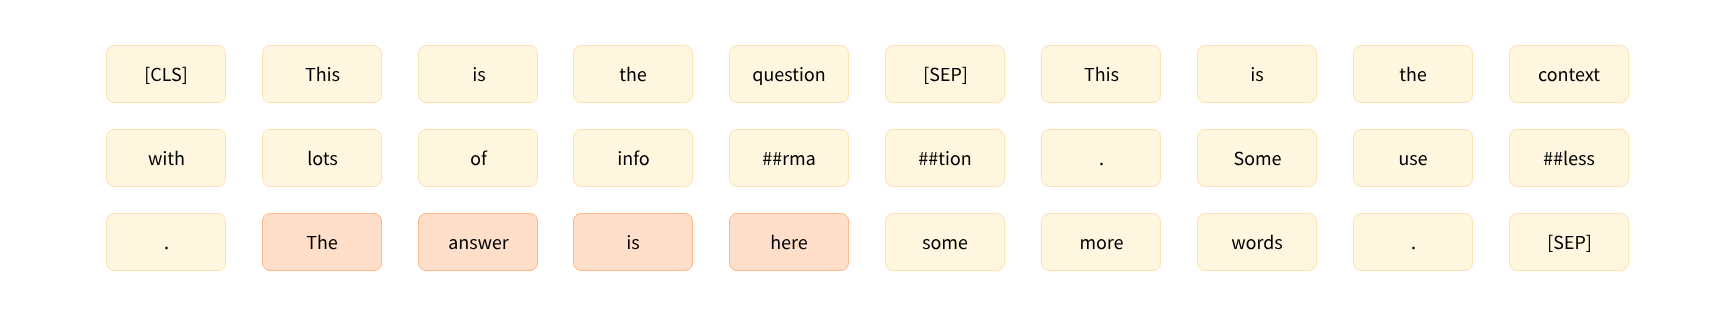

Models for question answering work a little differently from the models we’ve seen up to now. Using the picture above as an example, the model has been trained to predict the **index of the token starting the answer** (here 21) and the **index of the token where the answer ends** (here 24). This is why those models don’t return one tensor of logits but two: one for the logits corresponding to the start token of the answer, and one for the logits corresponding to the end token of the answer. Since in this case we have only one input containing 66 tokens, we get:

In [4]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

torch.Size([1, 67]) torch.Size([1, 67])


## Mask the question

To convert those logits into probabilities, we will apply a softmax function — but before that, we need to make sure we **mask the indices that are not part of the context**. Our input is `[CLS] question [SEP] context [SEP]`, so we need to mask the tokens of the question as well as the `[SEP]` token. We’ll keep the `[CLS]` token, however, as some models use it to indicate that the answer is not in the context.

Since we will apply a softmax afterward, we just need to replace the logits we want to mask with a large negative number.

In [5]:
import torch

# sequence_ids are the IDs to identify different sequences in the batch
# [0, 0, 0, ..., 0, 1, 1, 1, ..., 1, 2, 2, 2, ..., 2, ...]
sequence_ids = inputs.sequence_ids()

# Mask everything apart from the tokens of the context
# the context cames in second place, so the sequence_ids are 1
# we want to mask everything that is not part of the context
mask = [i != 1 for i in sequence_ids]
mask[0] = False  # Unmask the [CLS] token
mask = torch.tensor(mask)[None]  # Add a batch dimension

# Set the masked logits to -10e10
start_logits[mask] = -10e10
end_logits[mask] = -10e10

Now that we have properly masked the logits corresponding to positions we don’t want to predict, we can apply the **softmax**:

In [6]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)[0]
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)[0]

## Select the answer

At this stage, we could take the argmax of the start and end probabilities — but **we might end up with a start index that is greater than the end index**, so we need to take a few more precautions. We will compute the probabilities of each possible start_index and end_index where `start_index <= end_index`, **then take the tuple (start_index, end_index) with the highest probability**.

Assuming the events “The answer starts at start_index” and “The answer ends at end_index” to be independent, the probability that the answer starts at start_index and ends at end_index is:

$$
start\_probabilities[start\_index] \times end\_probabilities[end\_index]
$$

So, to compute all the scores, we just need to compute all the products
$start\_probabilities[start\_index] \times end\_probabilities[end\_index]$
where `start_index <= end_index`.

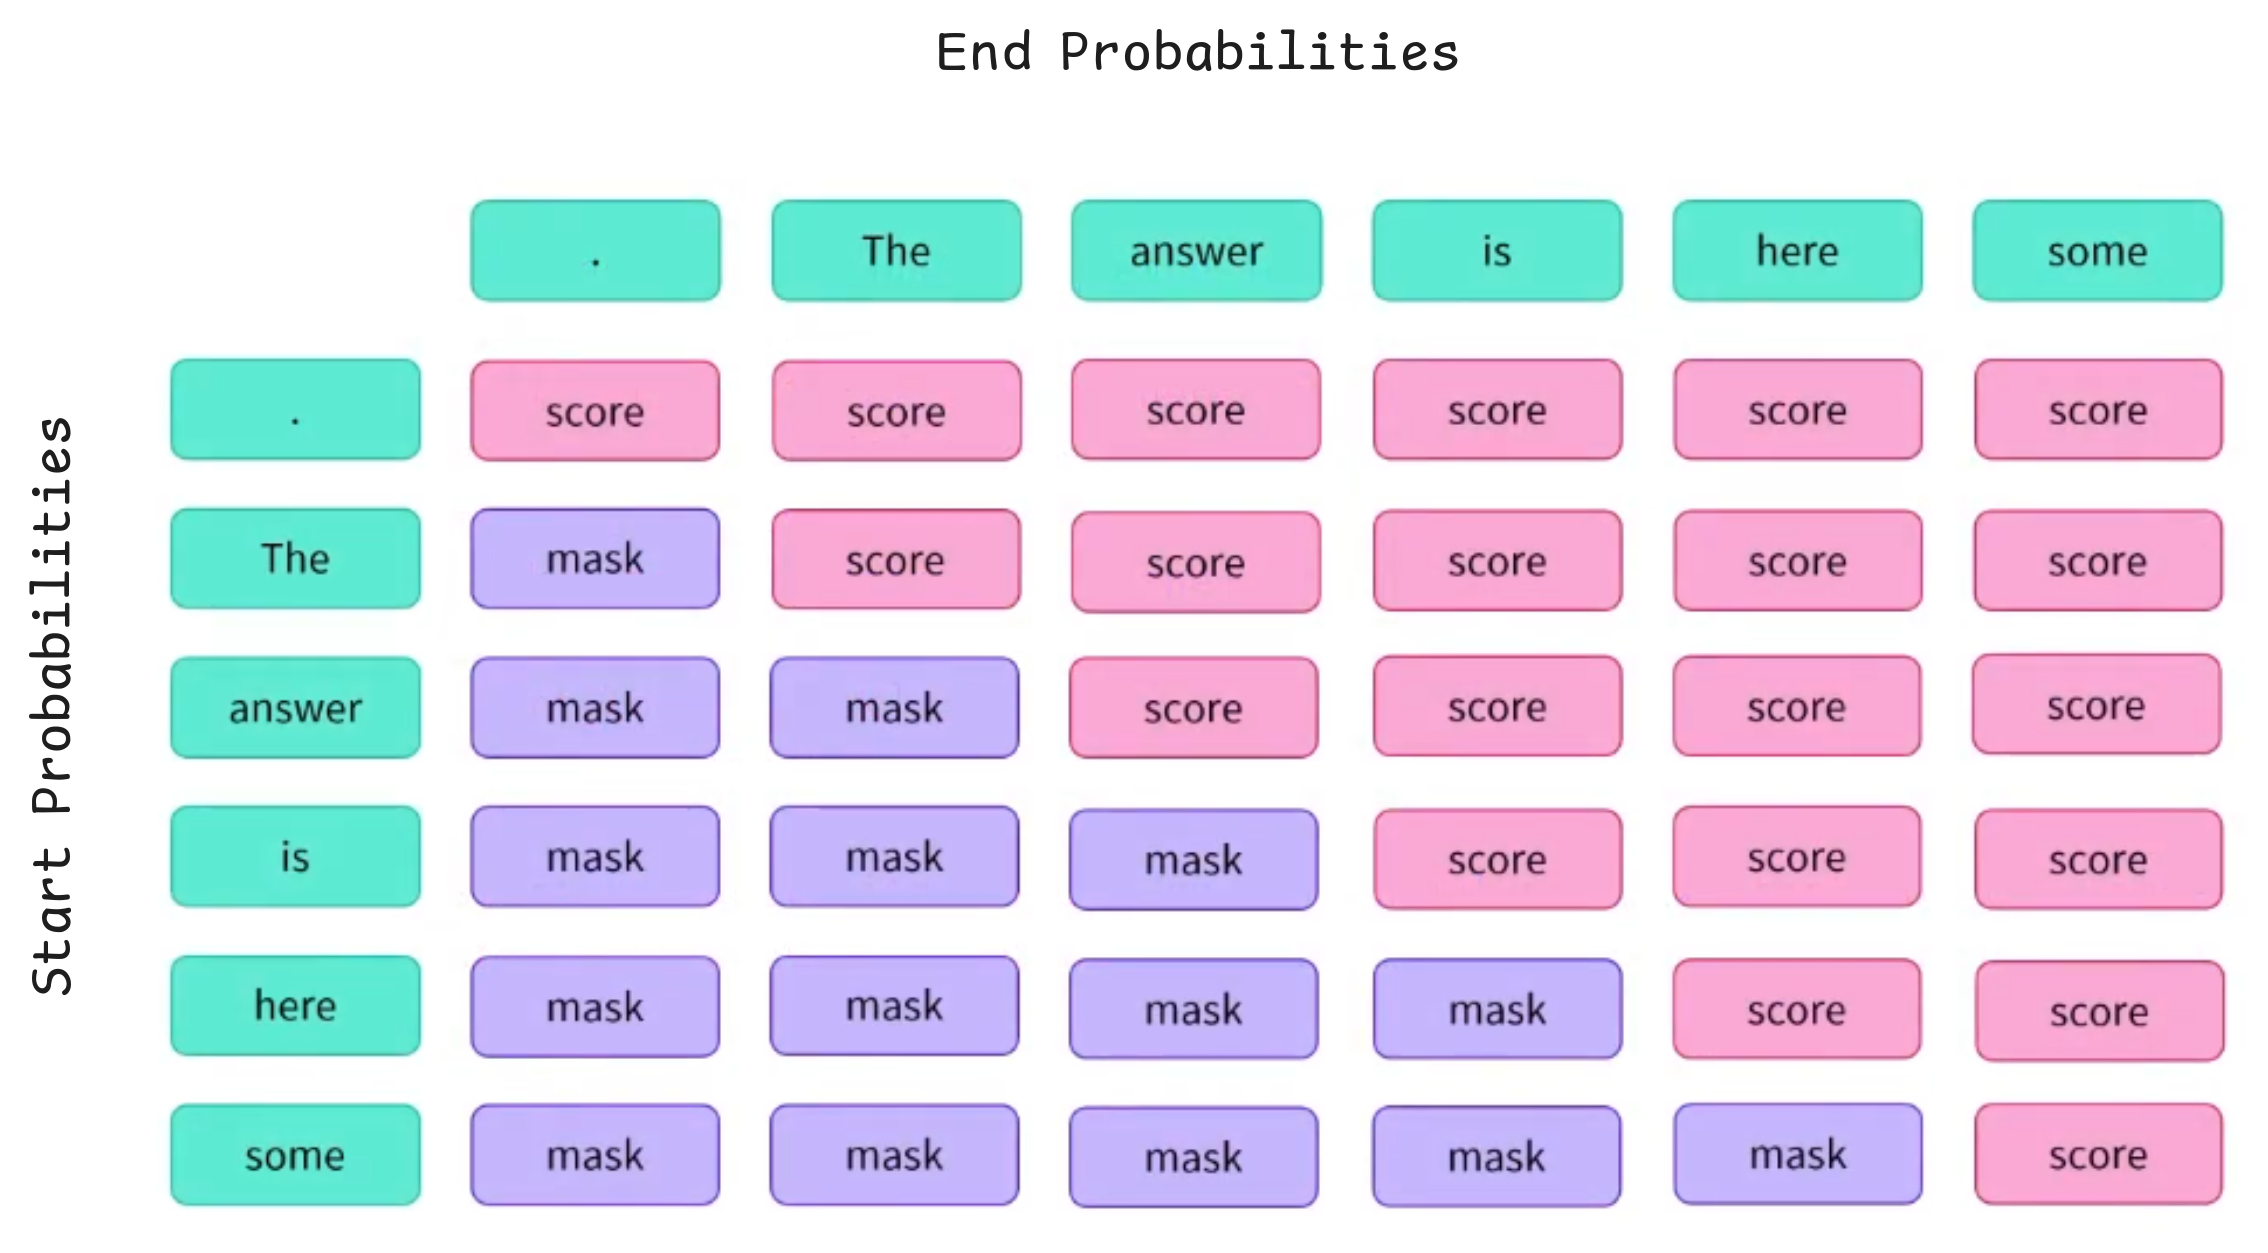

First let’s compute all the possible products:

In [11]:
scores = start_probabilities[:, None] * end_probabilities[None, :]
scores.shape

torch.Size([67, 67])

Then we’ll **mask the values where `start_index > end_index` by setting them to 0** (the other probabilities are all positive numbers). The `torch.triu()` function returns the upper triangular part of the 2D tensor passed as an argument, so it will do that masking for us:

In [12]:
scores = torch.triu(scores)

Now we just have to get the index of the maximum. Since PyTorch will return the index in the flattened tensor, we need to use the floor division `//` and modulus `%` operations to get the `start_index` and `end_index`.

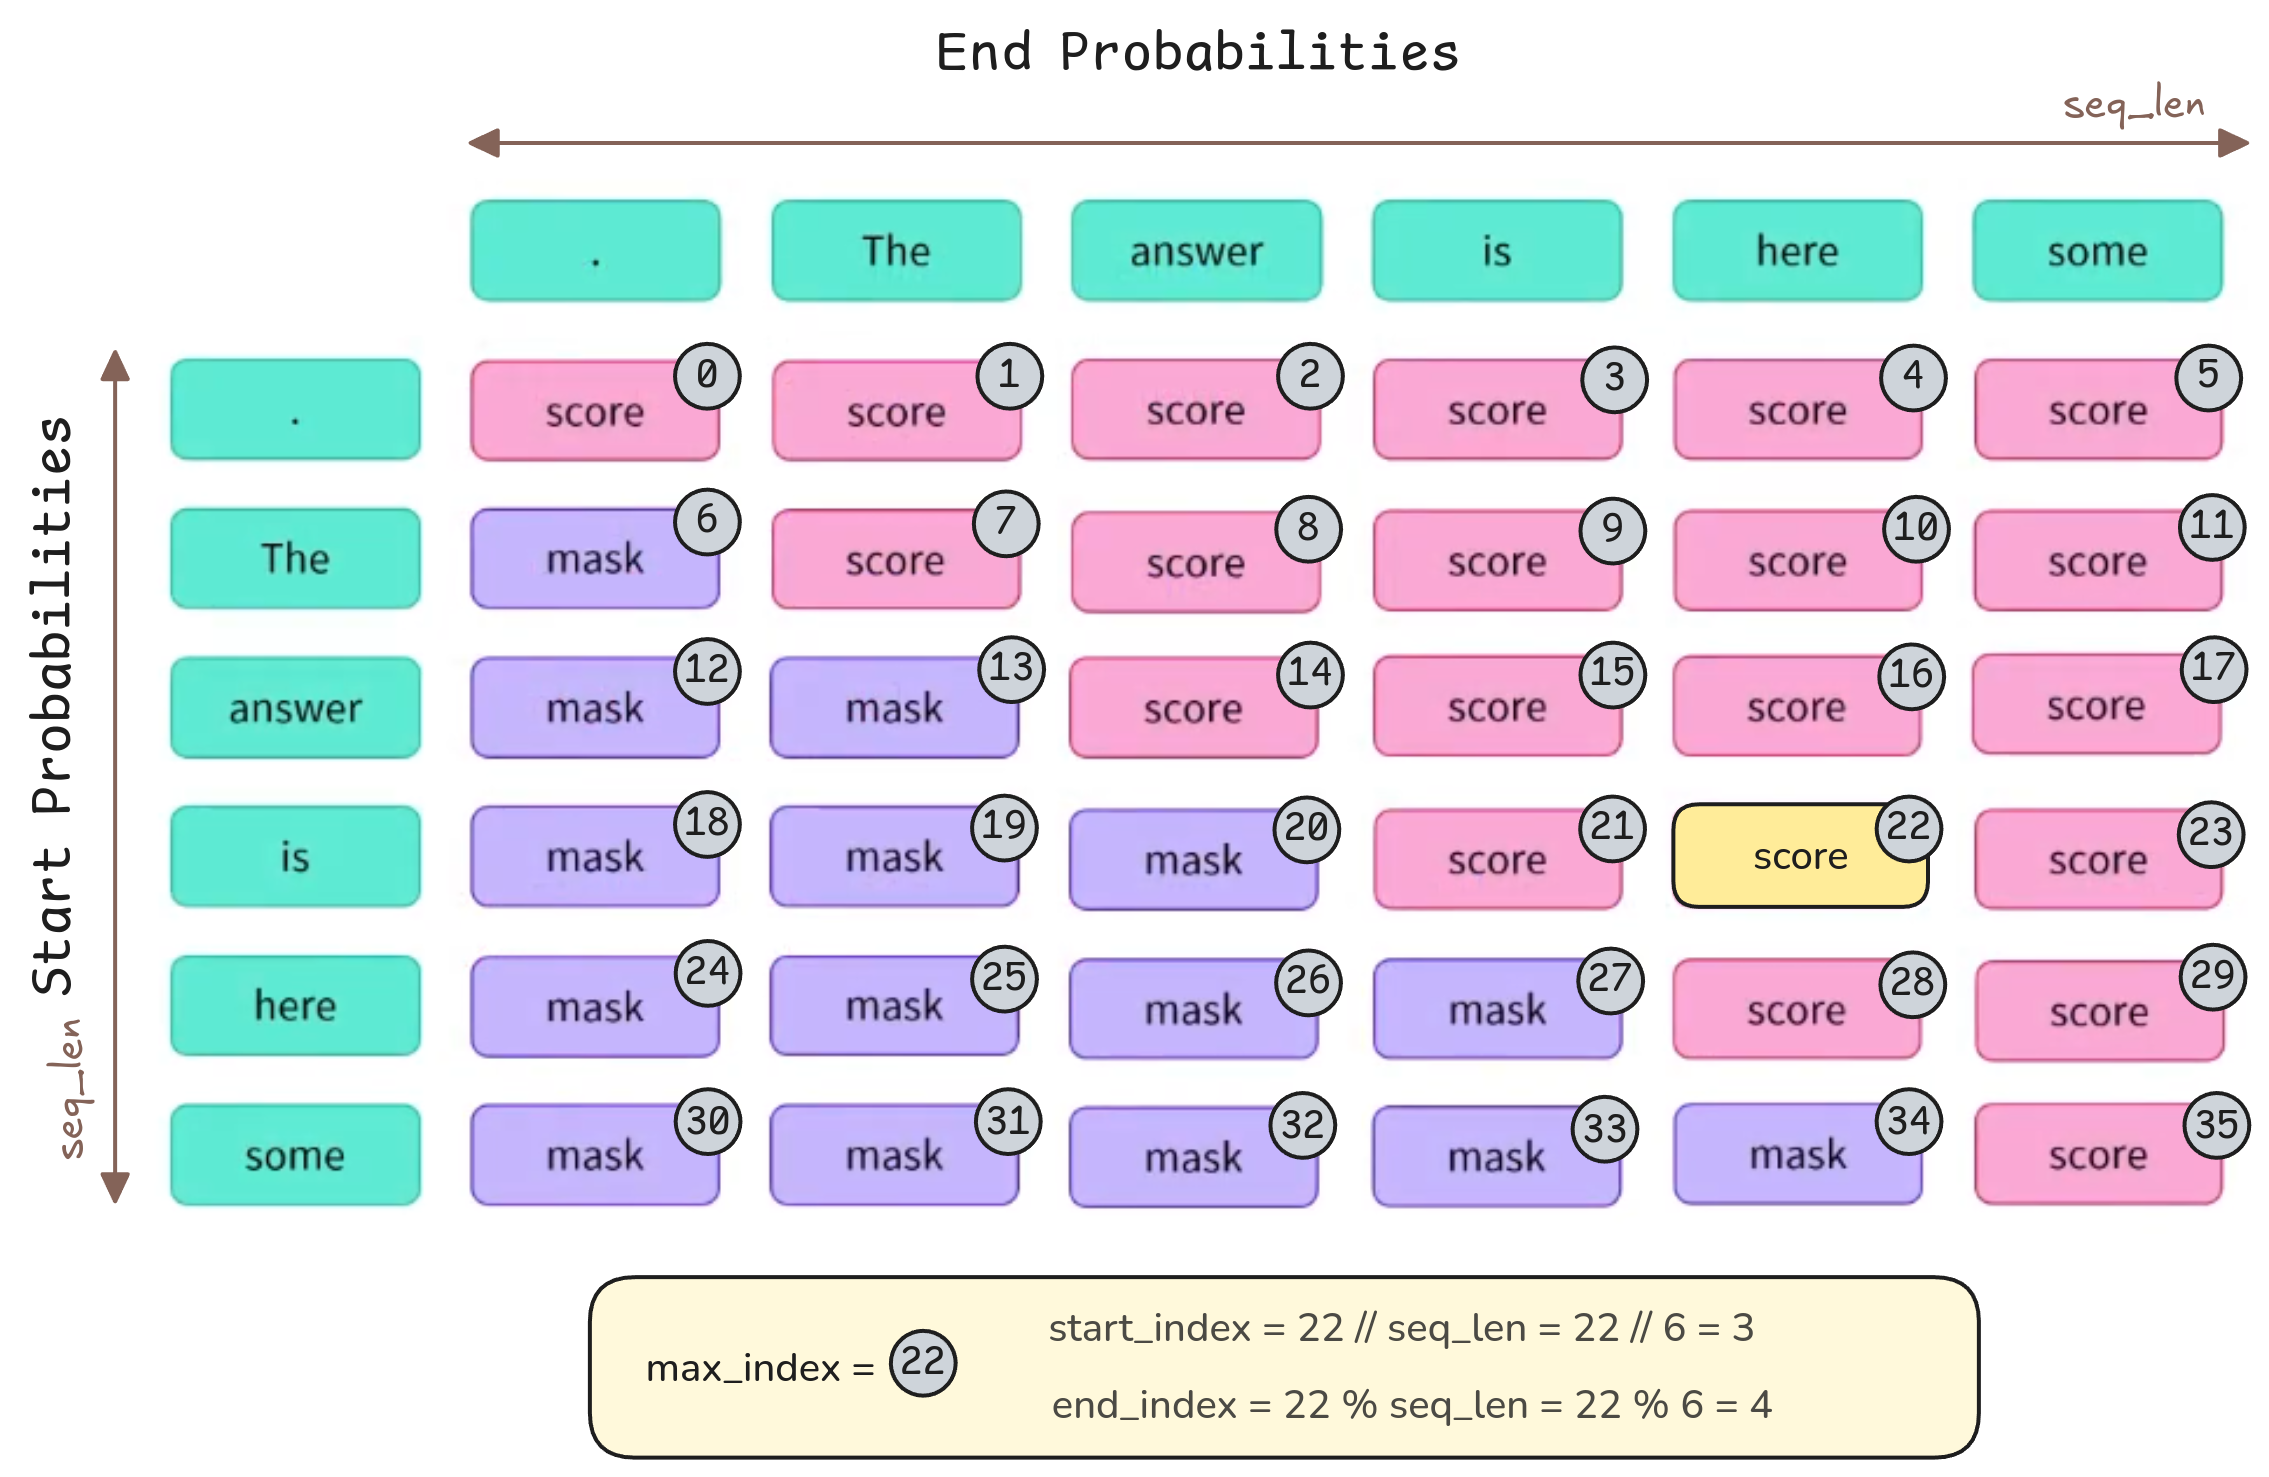

In [21]:
max_index = scores.argmax().item()
seq_len = scores.shape[0]
start_index = max_index // seq_len
end_index = max_index % seq_len
print(scores[start_index, end_index])

tensor(0.9803, grad_fn=<SelectBackward0>)


We have the `start_index` and `end_index` of the answer in terms of tokens, so now we just need to convert to the character indices in the context. This is where the **offsets** will be super useful. We can grab them and use them:

In [26]:
inputs_with_offsets = tokenizer(question, context, return_offsets_mapping=True)
offsets = inputs_with_offsets["offset_mapping"]
# The offsets are tuples indicating where a token starts and ends in the text
start_char, _ = offsets[start_index]
_, end_char = offsets[end_index]
answer = context[start_char:end_char]

In [27]:
result = {
    "answer": answer,
    "start": start_char,
    "end": end_char,
    "score": scores[start_index, end_index],
}
print(result)

{'answer': 'Jax, PyTorch, and TensorFlow', 'start': 78, 'end': 106, 'score': tensor(0.9803, grad_fn=<SelectBackward0>)}


# Handling long contexts

If we try to tokenize the question and long context we used as an example previously, we’ll get a number of tokens higher than the maximum length used in the `question-answering` pipeline (which is 384):

In [28]:
long_context = """
🤗 Transformers: State of the Art NLP

🤗 Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

🤗 Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and
then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and
can be modified to enable quick research experiments.

Why should I use transformers?

1. Easy-to-use state-of-the-art models:
  - High performance on NLU and NLG tasks.
  - Low barrier to entry for educators and practitioners.
  - Few user-facing abstractions with just three classes to learn.
  - A unified API for using all our pretrained models.
  - Lower compute costs, smaller carbon footprint:

2. Researchers can share trained models instead of always retraining.
  - Practitioners can reduce compute time and production costs.
  - Dozens of architectures with over 10,000 pretrained models, some in more than 100 languages.

3. Choose the right framework for every part of a model's lifetime:
  - Train state-of-the-art models in 3 lines of code.
  - Move a single model between TF2.0/PyTorch frameworks at will.
  - Seamlessly pick the right framework for training, evaluation and production.

4. Easily customize a model or an example to your needs:
  - We provide examples for each architecture to reproduce the results published by its original authors.
  - Model internals are exposed as consistently as possible.
  - Model files can be used independently of the library for quick experiments.

🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question_answerer(question=question, context=long_context)

{'score': 0.9714871048927307,
 'start': 1892,
 'end': 1919,
 'answer': 'Jax, PyTorch and TensorFlow'}

In [29]:
inputs = tokenizer(question, long_context)
print(len(inputs["input_ids"]))

461


So, we’ll need to truncate our inputs at that **maximum length**. There are several ways we can do this, but **we don’t want to truncate the question**, only the context. Since the context is the second sentence, we’ll use the `"only_second"` truncation strategy. The problem that arises then is that the answer to the question may not be in the truncated context. Here, for instance, we picked a question where the answer is toward the end of the context, and when we truncate it that answer is not present.

By default the question-answering pipeline uses a **`maximum length`** of 384, as we mentioned earlier, and a **`stride`** of 128 (overlap between the chunks), which correspond to the way the model was fine-tuned (you can adjust those parameters by passing max_seq_len and stride arguments when calling the pipeline). We will thus use those parameters when tokenizing. We’ll also add **`padding`** (to have samples of the same length, so we can build tensors) as well as ask for the offsets:

In [36]:
inputs = tokenizer(
    question,
    long_context,
    stride=128,  # Overlap the chunks by 128 tokens
    max_length=384,  # Mas sequence length
    padding="longest",  # For batch processing
    truncation="only_second",  # Truncate only the context
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(inputs.keys())

dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])


- `overflow_to_sample_mapping`: Is a map that tells us which sentence each of the results corresponds to. Here we only have one sentence, so we only have [0,0] (two chunks for the same sentence).
- `offset_mapping`: This is a tuple of two lists of offsets.

Those inputs will contain the input IDs and attention masks the model expects, as well as the offsets and the `overflow_to_sample_mapping` we just talked about. Since those two are not parameters used by the model, we’ll pop them out of the inputs (and we won’t store the map, since it’s not useful here) before converting it to a tensor:

In [37]:
_ = inputs.pop("overflow_to_sample_mapping")
offsets = inputs.pop("offset_mapping")  # Saved for post-processing

inputs = inputs.convert_to_tensors("pt")
# (batch_size, sequence_length)
# our batch is 2 because we have two chunks
print(inputs["input_ids"].shape)

torch.Size([2, 384])


Our long context was split in two, which means that after it goes through our model, we will have two sets of start and end logits:

In [38]:
outputs = model(**inputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

torch.Size([2, 384]) torch.Size([2, 384])


Like before, we first **mask the tokens that are not part of the context before taking the softmax**. We also **mask all the padding tokens** (as flagged by the attention mask):

In [40]:
# sequence_ids are the IDs to identify different sequences in the batch
# [0, 0, 0, ..., 0, 1, 1, 1, ..., 1, 2, 2, 2, ..., 2, ...]
sequence_ids = inputs.sequence_ids()

# Mask everything apart from the tokens of the context
# the context cames in second place, so the sequence_ids are 1
# we want to mask everything that is not part of the context
mask = [i != 1 for i in sequence_ids]
mask[0] = False # Unmask the [CLS] token
mask = torch.logical_or(  # Mask all the [PAD] tokens
    torch.tensor(mask)[None],  # Maintain CLS and question 1s
    (inputs["attention_mask"] == 0)  # Mask [PAD] too to 1s
)

start_logits[mask] = -10e10
end_logits[mask] = -10e10

Then we can use the softmax to convert our logits to probabilities:

In [43]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)

The next step is similar to what we did for the small context, but we **repeat it for each of our two chunks**. We attribute a score to all possible spans of answer, then take the **span with the best score**:

In [44]:
candidates = []
# Zip the start and end probabilities of each chunk
for start_probs, end_probs in zip(start_probabilities, end_probabilities):
    scores = start_probs[:, None] * end_probs[None, :]
    idx = torch.triu(scores).argmax().item()

    start_idx = idx // scores.shape[1]
    end_idx = idx % scores.shape[1]
    score = scores[start_idx, end_idx].item()
    candidates.append((start_idx, end_idx, score))

print(candidates)

[(0, 18, 0.33867067098617554), (173, 184, 0.9714868664741516)]


**Those two candidates correspond to the best answers the model was able to find in each chunk**. The model is way more confident the right answer is in the second part (which is a good sign!). Now we just have to **map those two token spans to spans of characters in the context** (we only need to map the second one to have our answer, but it’s interesting to see what the model has picked in the first chunk).

The `offsets` we grabbed earlier is actually a list of offsets, with one list per chunk of text:

In [45]:
# Iterate over the candidates and offsets to retrieve the answer
for candidate, offset in zip(candidates, offsets):
    start_token, end_token, score = candidate
    # Take the span from the start to the end token
    start_char, _ = offset[start_token]
    _, end_char = offset[end_token]
    # Given the offset, cut the context to retrieve the answer
    answer = long_context[start_char:end_char]
    result = {"answer": answer, "start": start_char, "end": end_char, "score": score}
    print(result)

{'answer': '\n🤗 Transformers: State of the Art NLP', 'start': 0, 'end': 37, 'score': 0.33867067098617554}
{'answer': 'Jax, PyTorch and TensorFlow', 'start': 1892, 'end': 1919, 'score': 0.9714868664741516}
